In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm.notebook as tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torchvision import datasets
import pip
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix

In [ ]:
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*IMAGE TRANSFORMATIONS*

In [ ]:
#calcular la media y la desviacion tipica sobre el conjunto de imagenes 0-1
#Modelos de imagenet están pensados para tomar imagenes de 3 canales
#def apply_image(path):
  #Image.open(path).convert('RGB')
  #ImageDataLoader(loader = apply_image)

  #ImageAugmentation
# -Imagenes : Covid : 1000, Normal 1341, viral 1345 -Image Augmentation

#Modelos a aplicar con transfer learning: -SqueezeNet -MobileNetv2 -ResNet18 -DenseNet201 -VGG19 -WideResnet -ResNext

#Para evaluacion:

#-También aplicar 5-fold cross-validation (accuracy, sensitivity, precision....)

#Optimizador: -SGD con momentum 0.9

In [2]:

normalize_mean = [0.485,0.456,0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(), 
  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
  transforms.Normalize(normalize_mean, normalize_std)
])

In [5]:
!mkdir -p /my_data/

In [6]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip
   creating: /my_data/Viral Pneumonia/
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (10).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (100).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1000).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1001).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1002).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1003).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1004).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1005).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1006).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1007).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1008).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1009).png  
 extracting: /my_data/Viral Pneum

In [7]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/COVID.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/COVID.zip
   creating: /my_data/COVID/
   creating: /my_data/COVID/COVID/
 extracting: /my_data/COVID/COVID (1).png  
 extracting: /my_data/COVID/COVID (10).png  
 extracting: /my_data/COVID/COVID (100).png  
 extracting: /my_data/COVID/COVID (1000).png  
 extracting: /my_data/COVID/COVID (1001).png  
 extracting: /my_data/COVID/COVID (1002).png  
 extracting: /my_data/COVID/COVID (1003).png  
 extracting: /my_data/COVID/COVID (1004).png  
 extracting: /my_data/COVID/COVID (1005).png  
 extracting: /my_data/COVID/COVID (1006).png  
 extracting: /my_data/COVID/COVID (1007).png  
 extracting: /my_data/COVID/COVID (1008).png  
 extracting: /my_data/COVID/COVID (1009).png  
 extracting: /my_data/COVID/COVID (101).png  
 extracting: /my_data/COVID/COVID (1010).png  
 extracting: /my_data/COVID/COVID (1011).png  
 extracting: /my_data/COVID/COVID (1012).png  
 extracting: /my_data/COVID/COVID (1013).png  
 extracting: /my_data/COVID/COVID (101

In [8]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/NORMAL.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/NORMAL.zip
   creating: /my_data/NORMAL/
 extracting: /my_data/NORMAL/NORMAL (1).png  
 extracting: /my_data/NORMAL/NORMAL (10).png  
 extracting: /my_data/NORMAL/NORMAL (100).png  
 extracting: /my_data/NORMAL/NORMAL (1000).png  
 extracting: /my_data/NORMAL/NORMAL (1001).png  
 extracting: /my_data/NORMAL/NORMAL (1002).png  
 extracting: /my_data/NORMAL/NORMAL (1003).png  
 extracting: /my_data/NORMAL/NORMAL (1004).png  
 extracting: /my_data/NORMAL/NORMAL (1005).png  
 extracting: /my_data/NORMAL/NORMAL (1006).png  
 extracting: /my_data/NORMAL/NORMAL (1007).png  
 extracting: /my_data/NORMAL/NORMAL (1008).png  
 extracting: /my_data/NORMAL/NORMAL (1009).png  
 extracting: /my_data/NORMAL/NORMAL (101).png  
 extracting: /my_data/NORMAL/NORMAL (1010).png  
 extracting: /my_data/NORMAL/NORMAL (1011).png  
 extracting: /my_data/NORMAL/NORMAL (1012).png  
 extracting: /my_data/NORMAL/NORMAL (1013).png  
 extracting: /my_data/NORMAL/NORMAL

*PREPARAMOS DATASET

In [ ]:
def myloader(filename):
    return Image.open(filename).convert('RGB')

In [3]:
dataset = datasets.ImageFolder('/my_data', transform=transform)

In [ ]:
#dataset = datasets.ImageFolder('/my_data', transform=transform, loader = myloader)Preguntar lo de image

In [4]:
print(dataset.class_to_idx) #Clases asignadas en la función imagefolder a las tres carpetas

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 5080
    Root location: /my_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
len(dataset)

5080

DIVIDIMOS DATASET EN TRAIN, VALIDACIÓN Y TEST

In [5]:
n_train = int(0.7*len(dataset))
n_valid_test = (len(dataset)-n_train)
n_valid = int((0.5*(n_valid_test)))
n_test = int((0.5*(n_valid_test)))

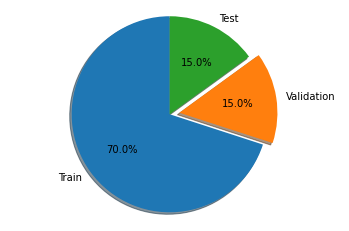

In [6]:
import matplotlib.pyplot as plt


labels = 'Train', 'Validation', 'Test'
sizes = [n_train, n_valid, n_test]
explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [7]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

PREPARAMOS DATALOADER

In [8]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [9]:
dataloaders_entrenamiento = {"Train":train_loader, "Validation":val_loader}
data_sizes = {x: len(dataloaders_entrenamiento[x].sampler) for x in ['Train','Validation']}

In [10]:
data_sizes

{'Train': 3556, 'Validation': 762}

VISUALIZACIÓN DE LOS DATOS

COVID IMAGE:

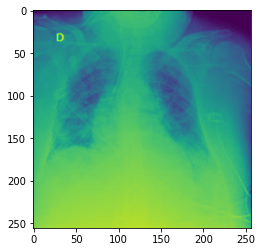

In [ ]:
image = plt.imread('/my_data/COVID/COVID (100).png')
plt.imshow(image)

NORMAL IMAGE:

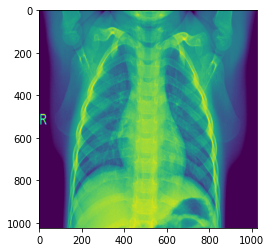

In [ ]:
image = plt.imread('/my_data/NORMAL/NORMAL (1009).png')
plt.imshow(image)

VIRAL PNEUMONIA IMAGE

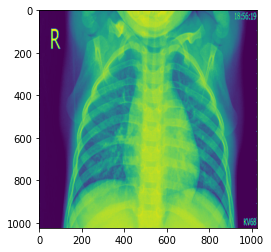

In [ ]:
image = plt.imread('/my_data/Viral Pneumonia/Viral Pneumonia (1030).png')
plt.imshow(image)

In [ ]:
dataset.classes

['COVID', 'NORMAL', 'Viral Pneumonia']

In [ ]:
dataset.class_to_idx

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

CREANDO EL MODELO SIN TRANSFER LEARNING CON REDES NEURONALES

In [ ]:
#How do we calculate the in_features for the linear layer
#Image =224*224*3  
#224-3(filter_size)+1=222
#Output = 222 *222
#222*222*num_of_filters --->maxpool(2,2)---> 222/2 =8*111*111


In [11]:
import torch.nn.functional as F
#MODELO 1:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride = (2,2), padding =(3,3))
    self.batch1 = nn.BatchNorm2d(32)
    self.pool1  = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride =(2,2), padding=(1,1))
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride =(2,2), padding=(1,1))
    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride =(1,1), padding=(1,1))
    self.reshape = 256
    self.fc1   = nn.Linear(7372800,512)
    self.fc2   = nn.Linear(512, 3)
  
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = x.view(-1, 7372800)#Reshape para la linear 100352
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
    



In [17]:
import torch.nn.functional as F
#MODELO 1:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride = (2,2), padding =(3,3))
    self.batch1 = nn.BatchNorm2d(32)
    self.pool1  = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride =(2,2), padding=(1,1))
    self.pool2  = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride =(2,2), padding=(1,1))
    self.pool3  = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride =(1,1), padding=(1,1))
    self.pool4  = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.reshape = 256
    self.fc1   = nn.Linear(262144,512)
    self.fc2   = nn.Linear(512, 3)
  
  def forward(self, x):
    x = self.pool1((F.relu(self.conv1(x))))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))
    x = x.view(-1, 262144)#Reshape para la linear 100352
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [18]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val,
                          figsize=(12,6)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(acc_tr)),  100*np.array(acc_tr))
    plt.plot(1+np.arange(len(acc_val)), 100*np.array(acc_val))
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(acc_tr)), np.array(loss_tr))
    plt.plot(1+np.arange(len(acc_val)), np.array(loss_val))
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [19]:

model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


In [20]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)


In [21]:
def train_covid(model, loss_fn, optimizer, epochs=10):
    loss_tr = []
    acc_tr  = []
    loss_val = []
    acc_val = []
    since = time.time()
    best_loss = np.inf
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_acc = 0
            

            #Cogemos los inputs y los almacenamos en un dataloader filtrado por Train y Validation, para poder entrenarlos simultáneamente
            for inputs, labels in tqdm.tqdm(dataloaders_entrenamiento[phase], desc=phase, leave=False):

                #Hacemos 0 los parámetros del gradiente.
                optimizer.zero_grad()

                # BACKWARD PROPAGATION. Se calculan gradientes y se actualizan los pesos

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                if phase == 'Train':
                      loss.backward()
                      optimizer.step()
                
              
                 # Acumulamos las estadísticas de loss y accuracy en variables
                current_loss += loss.item() * inputs.size(0)
                current_acc += torch.sum(preds == labels.data)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_acc.double() / data_sizes[phase]
            if phase == 'Validation':
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_tr.append(epoch_loss)
                acc_tr.append(epoch_acc)

            # EARLY STOPPING
            if phase == 'Validation' and epoch_loss < best_loss:
                print('Validation loss decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss 
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)

    grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val,
                          figsize=(10,4))
    return model

In [22]:
base_model = train_covid(model, loss_fn, optimizer, epochs=10)

Epoch 1/10
----------


RuntimeError: ignored

RESULTADOS OBTENIDOS

In [ ]:
model.eval()
correct = 0
total = 0
y_pred = []
y_real = []
with torch.no_grad():
  for data in test_loader:
    #inputs para la evaluación
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    #Para calcular las correctas encuentra la suma cuando las etiquetas son iguales a las predecidas calculadas anteriormente
    correct += (predicted == labels).sum().item()
    y_pred.extend(predicted.numpy().tolist())
    y_real.extend(labels.numpy().tolist())
    #y_pred.extend(predicted.numpy().tolist())
    print(predicted)
    print(labels)
#Dividimos correctas entre totales para calcular la precisión
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

tensor([0, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1, 0, 0])
tensor([0, 0, 2, 1, 1, 2, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0])
tensor([2, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0])
tensor([1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0])
tensor([0, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 2, 2])
tensor([0, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1])
tensor([0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0])
tensor([0, 2, 0, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0])
tensor([0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0])
tensor([0, 0, 2, 0, 0, 2, 2, 0, 1, 1, 0, 0, 1, 1, 2, 0])
tensor([0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2])
tensor([0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 1, 2, 2])
tensor([0, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2])
tensor([0, 1, 2, 2, 1, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 2])
tensor([1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 1])
tensor([1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1, 2, 0, 0, 1])
tensor([2, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 1, 0, 0, 2])
tensor([1, 2, 0, 0, 0, 1, 0, 2,

(array([256.,   0.,   0.,   0.,   0.,  74.,   0.,   0.,   0., 178.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

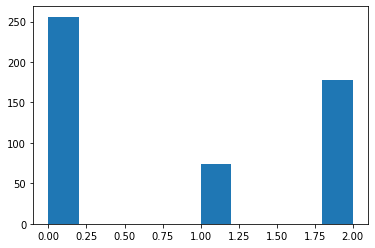

In [ ]:


import matplotlib.pyplot as plt
plt.hist(y_pred)


CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_pred, y_real))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       256
           1       0.44      0.82      0.57        74
           2       0.79      0.58      0.67       178

    accuracy                           0.77       508
   macro avg       0.72      0.76      0.72       508
weighted avg       0.82      0.77      0.78       508



In [ ]:
#El datagen proporciona el predict_proba en vez del predict. Para pasar
# de un predict_proba a un predict, simplemente tenemos que utilizar argmax
conf_matrix= confusion_matrix(y_pred, y_real)

In [ ]:
dataset_indices=dataset.class_to_idx
import seaborn as sn

In [ ]:
print(dataset_indices)

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [ ]:
conf_matrix = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)

[Text(32.99999999999999, 0.5, 'True label'),
 Text(0.5, 15.0, 'Predicted label')]

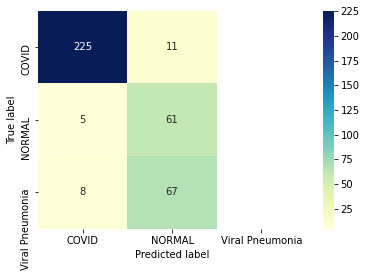

In [ ]:
conf_matrix = pd.DataFrame(conf_matrix, columns=dataset_indices, index=dataset_indices)
ax = sn.heatmap(conf_matrix, annot=True, cmap='YlGnBu', fmt='g')
ax.set(xlabel='Predicted label', ylabel='True label')

In [ ]:
test_generator.class_indices

In [ ]:
x = torch.zeros(1,3,224,224)
x,xcon = model.forward_heat(x)

print(x.shape)
print(xcon.shape)

_,args = torch.max(x,dim=1)


vjp = torch.zeros(1,3) 
vjp[:,args] = 1

grad = torch.autograd.grad(x,xcon, grad_outputs = vjp)[0]
print(grad.shape)

torch.Size([1, 3])
torch.Size([1, 256, 28, 28])
tensor([1])
torch.Size([1, 256, 28, 28])


In [ ]:
def last_layer(Model):
  

In [ ]:
import tensorflow as tf

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["female"]]
    print("Probabilidad clase female: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["male"]]
    print("Probabilidad clase male  : {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

VISUALIZACIÓN DE LAS PREDICCIONES

In [ ]:
class_names=dataset.classes
def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))

    for i, image in enumerate(images): 
        plt.subplot(6,4,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'Actual : {class_names[int(labels[i].numpy())]}/ Predicted: {class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

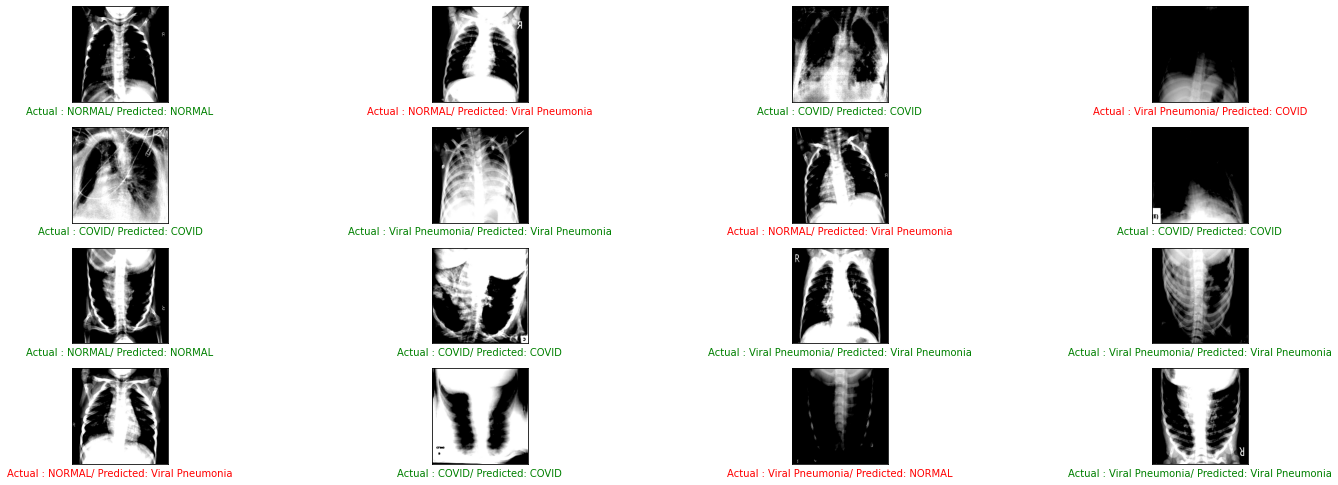

In [ ]:
def show_preds() :
  model.eval()
  images, labels = next(iter(test_loader))
  outputs = model(images)
  _, preds = torch.max(outputs, 1)
  show_images(images, labels, preds)
show_preds()